***Before building up a full fledged data generation process, we use the function on a single signal data to get a fair idea on how each functions works.***

In [4]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-07-03 10:51:06.510606: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-03 10:51:06.583747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751539866.613817    3577 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751539866.621121    3577 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751539866.673848    3577 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[]


2025-07-03 10:51:09.784935: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


/usr/local/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


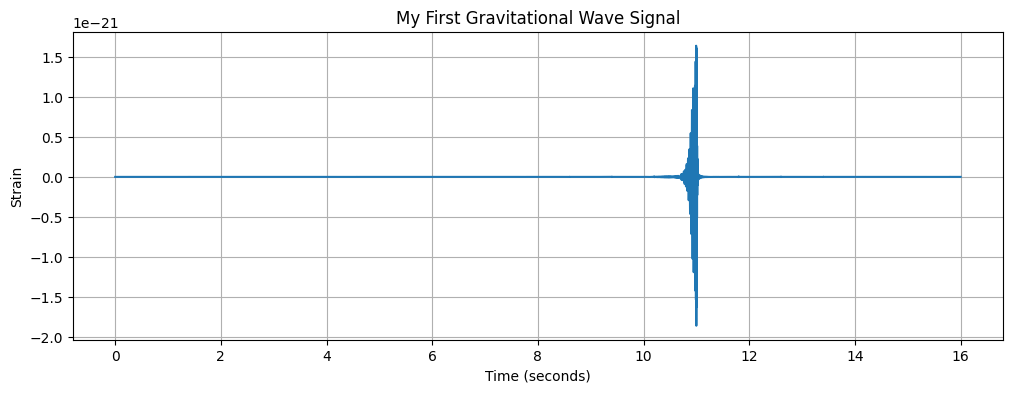

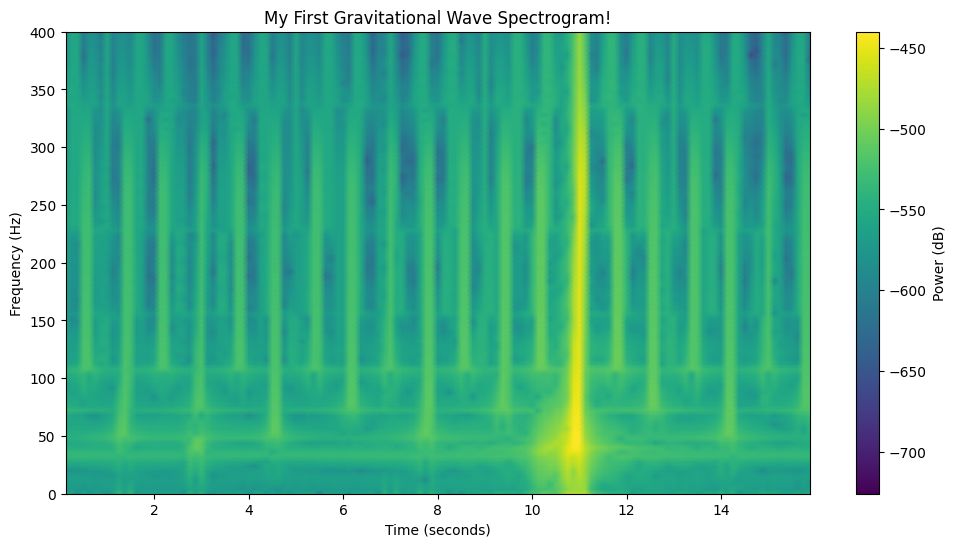

/usr/local/lib/python3.10/site-packages/pycbc/scheme.py:211: RuntimeWarning: divide by zero encountered in divide
  return schemed_fn(*args, **kwds)
/usr/local/lib/python3.10/site-packages/pycbc/scheme.py:211: RuntimeWarning: invalid value encountered in divide
  return schemed_fn(*args, **kwds)
/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/site-packages/pycbc/types/array.py:390: RuntimeWarning: divide by zero encountered in divide
  return self._data.__rtruediv__(other)
/usr/local/lib/python3.10/site-packages/pycbc/types/array.py:383: RuntimeWarning: invalid value encountered in divide
  return self._data / other


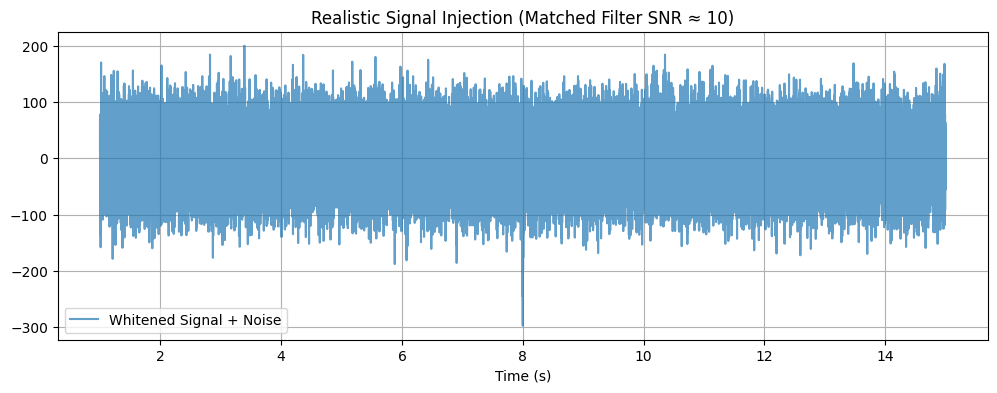

In [1]:
from pycbc.waveform import get_td_waveform
from pycbc.noise import noise_from_psd
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter import sigma
from pycbc.types import TimeSeries
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
import numpy as np

sample_rate = 4096

# --- Step 1: Generating Gravitational Wave Signal ---
hp, hc = get_td_waveform(
    approximant="IMRPhenomXPHM",
    mass1= np.random.uniform(5,80),
    mass2= np.random.uniform(5,80),
    delta_t=1.0/4096,
    spin1z=np.random.uniform(-0.9, 0.9),
    spin2z=np.random.uniform(-0.9, 0.9),
    distance=np.random.uniform(300, 800),
    inclination=np.random.uniform(0, np.pi),
    f_lower=40
)

#Plotting the time domain graph of signal
time = [i * hp.delta_t for i in range(0, len(hp))]

plt.figure(figsize=(12, 4))
plt.plot(time, hp)
plt.xlabel('Time (seconds)')
plt.ylabel('Strain')
plt.title('My First Gravitational Wave Signal')
plt.grid(True)
plt.show()

f, t, Sxx = spectrogram(
        hp, 
        fs=sample_rate, 
        nperseg = 1024,
        noverlap = 512
    )
plt.figure(figsize=(12, 6))
plt.pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (seconds)')
plt.title('My First Gravitational Wave Spectrogram!')
plt.colorbar(label='Power (dB)')
plt.ylim(0, 400)  # Focus on GW frequency range
plt.show()

# --- Step 2: Generating Realistic aLIGO Noise ---
psd = aLIGOZeroDetHighPower(
    len(hp)//2 + 1, 
    1.0/(len(hp)*hp.delta_t), 
    40)
noise = noise_from_psd(length=len(hp), delta_t=hp.delta_t, psd=psd)

# --- Step 3: Rescaling the Signal for Target Matched Filter SNR ---
target_snr = 10

signal_ts = TimeSeries(hp.numpy(), delta_t=hp.delta_t)
noise_ts = TimeSeries(noise.numpy(), delta_t=hp.delta_t)

# Computing the current SNR
optimal_snr = sigma(signal_ts, 
                    psd = psd, 
                    low_frequency_cutoff = 20)

scaling_factor = target_snr / optimal_snr
scaled_signal = signal_ts * scaling_factor

# Injecting the signal into noise
injected_ts = scaled_signal + noise_ts

# --- Step 4: Whitening (Realistic for Visual or ML Detection) ---
whitened_signal = scaled_signal.whiten(4, 2)
whitened_noise = noise_ts.whiten(4, 2)
whitened_injected = injected_ts.whiten(4, 2)

# --- Step 5: Plotting Whitened Data ---
plt.figure(figsize=(12, 4))
plt.plot(whitened_injected.sample_times, whitened_injected, label="Whitened Signal + Noise", alpha=0.7)
plt.legend()
plt.xlabel("Time (s)")
plt.title(f"Realistic Signal Injection (Matched Filter SNR ≈ {target_snr})")
plt.grid(True)
plt.show()